In [2]:
import numpy as np, matplotlib.pyplot as plt, glob, os, pandas as pd, copy, \
    skimage.segmentation as segm, networkx as nx, simplification.cutil as simpl, \
    scipy.ndimage as ndimage, matplotlib.colors as mplcol, matplotlib.cm as cm, json
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook as tqdm
import shapely.ops, shapely.geometry as geom
from skimage.measure import label

#### Set color scheme

In [3]:
COLORS = [
    (0, 0, 0),
    (230, 159, 0),
#    (86, 180, 233),
    (0, 158, 115),
#    (240, 228, 66),
    (0, 114, 178),
#    (213, 94, 0),
    (204, 121, 167),
    
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
]
COLORS = [mplcol.rgb2hex(np.array(x) / 255.0) for x in COLORS]

In [4]:
COLORS_STAGES = {
    'protoweb': '#e69f00',
    'radii': '#009E73',
    'spiral_aux': '#56B4E9',
    'spiral_cap': '#CC79A7',
    'stabilimentum': '#0072B2'
}

### Specify data files to display

In [5]:
fnameP = 'rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.filtered2.npy'
fnameA = 'rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.filtered2.npy'
fnames = [fnameP, fnameA]

In [6]:
fnames = [[x for x in glob.glob('\\\\?\\Z:\\behavior\\*\\wavelet\\{}'.format(fn)) if 'RIG' not in x] for fn in fnames]
len(fnames[0]), len(fnames[1])

(21, 21)

In [7]:
fnameP = 'Y:/wavelet/rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd/'
fnameP+= 'rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameP = '\\\\?\\' + fnameP.replace('/', '\\')

fnameA = 'Y:/wavelet/rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd/'
fnameA+= 'rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameA = '\\\\?\\' + fnameA.replace('/', '\\')

fnamesShared = [fnameP, fnameA]

fnamesWatershed = [x.replace('.npy', '.smoothed.watershed.npy') for x in fnamesShared]
fnamesWatershed = [(x if os.path.exists(x) else None) for x in fnamesWatershed]
arrWatershed = [np.load(x) for x in fnamesWatershed]

In [8]:
# Find recording information
fnamesRecordingInfo = [[os.path.join(os.path.dirname(os.path.dirname(x)), 
    'recording.json') for x in fn] for fn in fnames]

def loadJSON(x):
    if os.path.exists(x):
        with open(x, 'r') as f:
            return json.load(f)
    else:
        return None
    
recordingInfo = [[loadJSON(x) for x in fn] for fn in fnamesRecordingInfo]

# Exclude recordings that are incomplete or invalid
useRecording = [[('stages' in ri and (isinstance(ri['stages']['radii'], list) or ri['stages']['radii'] > 0) and \
    ri['web_complete'] and ri['tracking_successful']) for ri in _recordingInfo] \
        for _recordingInfo in recordingInfo]

fnames = [[x for x, b in zip(fnames[k], useRecording[k]) if b] for k in range(len(fnames))]
recordingInfo = [[x for x, b in zip(recordingInfo[k], useRecording[k]) if b] for k in range(len(fnames))]

len(fnames[0]), len(fnames[1])

(21, 21)

In [9]:
# Fill in missing stage information, if necessary
for z in tqdm(range(len(recordingInfo)), leave=False):
    for i in tqdm(range(len(recordingInfo[z])), leave=False):
        s = recordingInfo[z][i]
        s['fname'] = glob.glob(os.path.abspath(os.path.join(fnames[z][i], 
            '../../croprot/*dlc_position_orientation.npy')))[0]
        
        # Does this recording.json file specify stage ranges, or starting points?
        for st in s['stages']:
            if s['stages'][st] == []:
                s['stages'][st] = []
            elif not isinstance(s['stages'][st][0], list):
                s['stages'][st] = [s['stages'][st], ]
        
        s['stagesOrg'] = copy.deepcopy(s['stages'])
        
        # Convert to indices used in analysis
        arrIdx = np.load(s['fname'].replace('_position_orientation.npy',
                                            '_abs_filt_interp_mvmt_noborder.idx.npy'))
        for st in s['stages']:
            for k in range(len(s['stages'][st])):
                for m in range(2):
                    s['stages'][st][k][m] = np.argmin(np.abs(np.argwhere(arrIdx).T[0] - s['stages'][st][k][m]))

##### Compute densities

In [10]:
rng = [[0,0] for z in range(len(fnames))]
for z in range(len(fnames)):
    allData = []
    for i in tqdm(range(len(fnames[z])), leave=False):
        allData.append(np.load(fnames[z][i])[:,0:2])
    allData = np.vstack(allData)
    #_min = np.nanmin(allData, axis=0)
    #_max = np.nanmax(allData, axis=0)
    #rng[z] = [[_min[0], _max[0]], [_min[1], _max[1]]]
    rng[z] = [[0, 1], [0, 1]]

In [11]:
Hs = [[], []]

for z in tqdm(range(len(fnames)), leave=False):
    for i in tqdm(range(len(fnames[z])), leave=False):
        _H = {}
        for stage in recordingInfo[z][i]['stages']:
            # Load embedded data
            arr = np.load(fnames[z][i]).copy()
            # Determine what frame ranges belong to this stage
            idxSS = np.full(arr.shape[0], False, dtype=np.bool)
            for i0, i1 in recordingInfo[z][i]['stages'][stage]:
                idxSS[i0:i1] = True
            # Keep only embedding data in the current stage
            arr = arr[idxSS]
            arr = arr[~np.any(np.isnan(arr), axis=1)]
            # Compute histogram
            H, _, _ = np.histogram2d(arr[:,0], arr[:,1], 
                bins=(200,200), range=rng[z])
            _H[stage] = H
        Hs[z].append(_H)

In [12]:
# Sum histograms by stage
HsByStage = [{stage:np.mean([(x[stage] / max(1, np.nansum(x[stage]))) for x in Hs[z][0:6]], axis=0) for stage in Hs[z][0]} for z in range(len(Hs))]

In [13]:
def clipToPercentile(H, perc = 99):
    a = np.clip(H, 0, np.percentile(H, perc))
    a /= np.max(a)
    return a

### Sketch of stages

In [14]:
# We use an arbitrary recording as illustration
fnamePos = glob.glob('Z:\\behavior\\*\\croprot\\e_2019-06-03-111304_dlc_position_orientation.npy')[0]

# Get the manual stage annotation info
fnameInfo = os.path.abspath(os.path.join(os.path.dirname(fnamePos), '../recording.json'))

In [15]:
exampleWeb = [xi for xi, x in enumerate(fnames[0]) if '6-3-19-e' in x][0]

In [16]:
def plotStages(ax, resVW = 100):
    # Load trajectory info
    xyAll = np.load(fnamePos)[:,0:2].astype(np.float32)
    xyAll = pd.DataFrame(xyAll).fillna(method='ffill').fillna(method='bfill').values.copy()
    
    # ...
    STAGES = ['protoweb', 'radii', 'spiral_aux', 'spiral_cap', 'stabilimentum']
    
    for istage, stage in enumerate(STAGES):
        xyIdx = np.full(xyAll.shape[0], False, dtype=np.bool)
        for rng in recordingInfo[0][exampleWeb]['stagesOrg'][stage]:
            xyIdx[rng[0]:rng[1]] = True
        
        xy = xyAll[xyIdx,:].copy()
        xy = xy[np.linalg.norm(xy - np.array(recordingInfo[0][exampleWeb]['center']), axis=1) < 580,:]
        xy = simpl.simplify_coords_vw(xy, resVW)
        segmentIDs = np.cumsum(np.linalg.norm(xy - np.roll(xy, 1, axis=0), axis=1) > 200)
        
        for sid in np.unique(segmentIDs):
            ax[istage].plot(xy[segmentIDs==sid, 0], xy[segmentIDs==sid, 1], 
                            color=COLORS_STAGES[stage], linewidth=1)
        
        ax[istage].set_axis_off()
        ax[istage].set_xlim(0, 1024)
        ax[istage].set_ylim(0, 1024)

### Define colors

In [17]:
COLORS = [
    (0, 0, 0),
    (230, 159, 0),
#    (86, 180, 233),
    (0, 158, 115),
#    (240, 228, 66),
    (0, 114, 178),
#    (213, 94, 0),
    (204, 121, 167)
]
COLORS = [mplcol.rgb2hex(np.array(x) / 255.0) for x in COLORS]

In [18]:
import colorcet
import matplotlib.colors
import matplotlib.cm as cm

class customColormap(matplotlib.colors.LinearSegmentedColormap):
    def __init__(self, *args, **kwargs):
        self.baseCM = cm.get_cmap('cet_CET_L17')
        self.N = self.baseCM.N
    def __call__(self, r, *args, **kwargs):
        def mapColor(x):
            _c = self.baseCM(0.0, *args, **kwargs)
            lim = 0.10
            if x >= lim:
                return self.baseCM((x-lim)/(1.0 - lim), *args, **kwargs)
            else: 
                if isinstance(_c[0], float):
                    z = (x / 0.05)
                    a = _c[0] * z + 1.0 * (1 - z)
                    b = _c[1] * z + 1.0 * (1 - z)
                    c = _c[2] * z + 1.0 * (1 - z)
                    _c = (a, b, c, 1.0)
                    return _c
                else:
                    z = (x / lim)
                    a = int(_c[0] * z + 255.0 * (1 - z))
                    b = int(_c[1] * z + 255.0 * (1 - z))
                    c = int(_c[2] * z + 255.0 * (1 - z))
                    _c = (a, b, c, 255)
                    return _c
        if r.ndim == 2:
            _c = self.baseCM(0.0, *args, **kwargs)
            cs = np.array([[mapColor(y) for y in x] for x in r], 
                dtype=np.float64 if isinstance(_c[0], float) else np.uint8)
            return cs
        elif r.ndim == 1:
            _c = self.baseCM(0.0, *args, **kwargs)
            cs = np.array([mapColor(y) for y in r], 
                dtype=np.float64 if isinstance(_c[0], float) else np.uint8)
            return cs
        else:
            print('!!')

In [19]:
COLORS_CLUSTERS = {
 'walk': '#0072b2',
 'one-leg-after-other': '#eee8c7',
 'extrude-slow': '#f0e442',
 'extrude': '#009e73',
 'left-leg': '#e69f00',
 'both-legs': '#ccc8a7',
 'stationary': '#000000',
 'stationary-posterior': '#666666',
 'stationary-anterior': '#666666',
 'stabilimentum': '#cc79a7',
 'noisy': None,
 'right-leg': '#56b4e9',
 'bend-abdomen': '#d55e00'
}

### Cluster boundaries

In [20]:
def toNumber(x):
    try:
        return int(x)
    except:
        return -1
    
def loadLabels(fnameLabels):
    txtClusterLabels = ''
    with open(fnameLabels, 'r') as f:
        txtClusterLabels = f.read()
    clusterLabels = {}
    curLabel = ''
    for line in txtClusterLabels.split('\n'):
        if ':' in line:
            curLabel = line[:line.find(':')]
        elif len(line.strip()) > 0:
            clusterLabels[curLabel] = [toNumber(x) for x in line.split(',') if toNumber(x) >= 0]
    return clusterLabels

fnameClusterLabelsA = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd\\cluster_names.txt'
fnameClusterLabelsP = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd\\cluster_names.txt'
fnamesLabels = (fnameClusterLabelsP, fnameClusterLabelsA)

clusterLabels = (loadLabels(fnamesLabels[0]), loadLabels(fnamesLabels[1]))
clusterLabelsUnique = list(set(list(clusterLabels[0].keys()) + list(clusterLabels[1].keys())))
clusterLabelsUnique = [x for x in clusterLabelsUnique if x not in ['noisy',]]

In [21]:
def maskToPerimeter(mask):
    mask[0,:] = False
    mask[-1,:] = False
    mask[:,0] = False
    mask[:,-1] = False
    
    polys = [geom.Polygon([[_x + dx, _y + dy] for dx, dy in [[0,0],[0,1],[1,1],[1,0]]]) for _x, _y in \
         np.argwhere(mask)]
    a = shapely.ops.cascaded_union(polys).exterior.coords.xy
    xy = np.hstack((np.array(a[0])[:,np.newaxis], np.array(a[1])[:,np.newaxis]))
    
    return xy

### Compose Figure

C:\Users\acorver\.conda\envs\spider\lib\site-packages\ipykernel_launcher.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


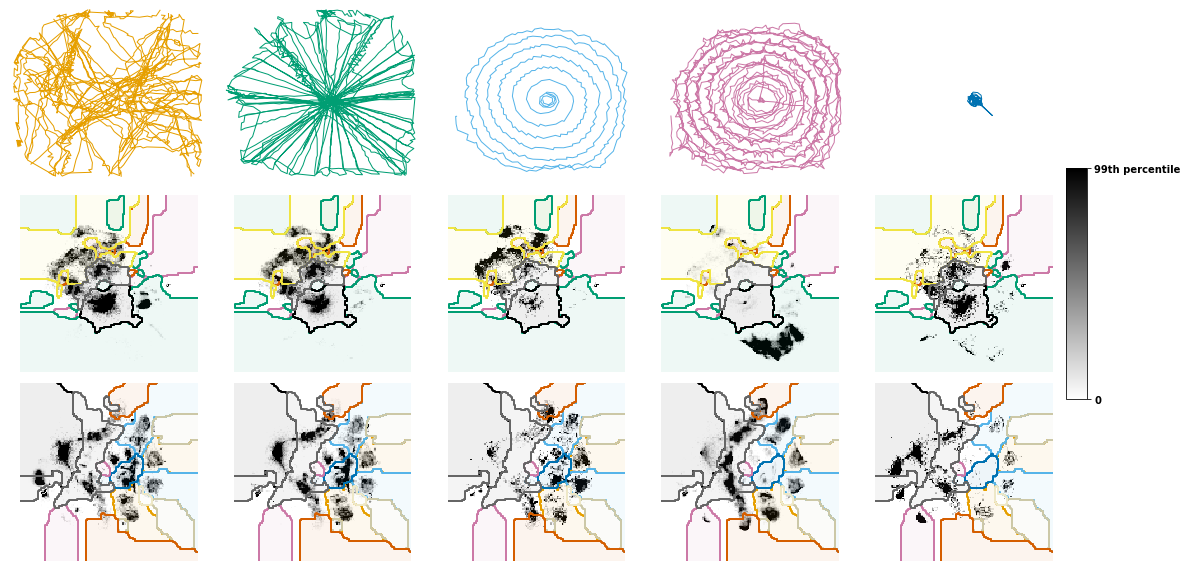

In [22]:
fig, ax = plt.subplots(3, 5, figsize=(15, 8))

_cm = 'gray_r' #customColormap()
_imsh = None
for z in range(len(HsByStage)):
    for i, stage in enumerate(HsByStage[z]):
        _imsh = ax[z+1][i].imshow(clipToPercentile(HsByStage[z][stage], 99), cmap=_cm)
        ax[z+1][i].set_axis_off()
        ax[z+1][i].set_xlim(30, 170)
        ax[z+1][i].set_ylim(30, 170)
        
# Plot cluster boundaries
for z in range(2):
    for k, clusterIDsKey in enumerate([x for x in clusterLabels[z] if x != 'noisy']):
        clusterIDs = clusterLabels[z][clusterIDsKey]
        # Plot clusters to highlight
        mask = None
        for exID, clusterID in enumerate(clusterIDs):
            _mask = (arrWatershed[z][:,:,0,1] == clusterID)
            # Merge masks
            mask = _mask if mask is None else (mask | _mask)

        # Split masks into contiguous submasks
        maskLabeled = label(ndimage.binary_dilation(ndimage.binary_erosion(mask, iterations=1), iterations=1))
        maskLabeledBg = np.max([np.sum(maskLabeled == x) for x in np.unique(maskLabeled)])
        isLabeled = False
        for maskID in np.unique(maskLabeled):
            if np.sum(maskLabeled == maskID) != maskLabeledBg:
                mask = (maskLabeled == maskID)
                mask[:25,:] = False
                mask[175:,:] = False
                mask[:,:25] = False
                mask[:,175:] = False
                pts = maskToPerimeter(mask)
                if pts is not None:
                    for i, stage in enumerate(HsByStage[z]):
                        ax[z+1][i].plot(pts[:,1], pts[:,0], linewidth=2, \
                            color=COLORS_CLUSTERS[clusterIDsKey])
                        ax[z+1][i].fill(pts[:,1], pts[:,0], linewidth=1, \
                            edgecolor=COLORS_CLUSTERS[clusterIDsKey], 
                            facecolor=COLORS_CLUSTERS[clusterIDsKey] + '11')
                        isLabeled = True

# Add color scale bar
cbar_ax = fig.add_axes([0.99, 0.3, 0.02, 0.4])
cbar = fig.colorbar(_imsh, cax=cbar_ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['0', '99th percentile'])

# Plot stages
plotStages(ax[0,:], resVW = 100)

# Save figure
fig.tight_layout()
#fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig3.pdf', dpi=1000)

C:\Users\acorver\.conda\envs\spider\lib\site-packages\ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


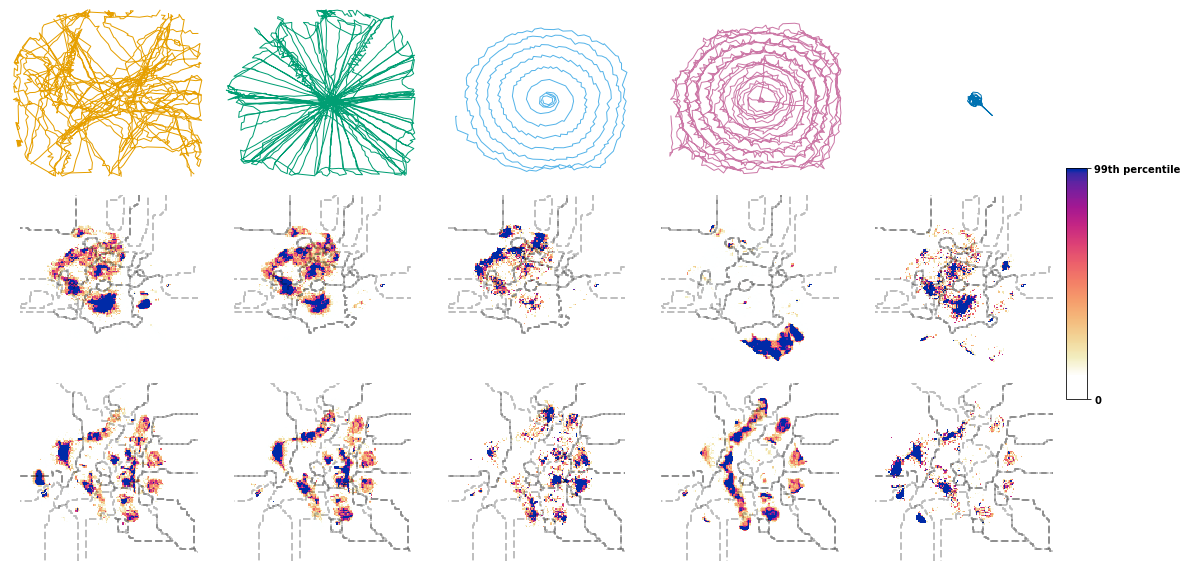

In [23]:
fig, ax = plt.subplots(3, 5, figsize=(15, 8))

_cm = customColormap() # 'gray_r'
_imsh = None
for z in range(len(HsByStage)):
    for i, stage in enumerate(HsByStage[z]):
        _imsh = ax[z+1][i].imshow(clipToPercentile(HsByStage[z][stage], 99), cmap=_cm)
        ax[z+1][i].set_axis_off()
        ax[z+1][i].set_xlim(30, 170)
        ax[z+1][i].set_ylim(30, 170)
        
# Plot cluster boundaries
for z in range(2):
    for k, clusterIDsKey in enumerate([x for x in clusterLabels[z] if x != 'noisy']):
        clusterIDs = clusterLabels[z][clusterIDsKey]
        # Plot clusters to highlight
        mask = None
        for exID, clusterID in enumerate(clusterIDs):
            _mask = (arrWatershed[z][:,:,0,1] == clusterID)
            # Merge masks
            mask = _mask if mask is None else (mask | _mask)

        # Split masks into contiguous submasks
        maskLabeled = label(ndimage.binary_dilation(ndimage.binary_erosion(mask, iterations=1), iterations=1))
        maskLabeledBg = np.max([np.sum(maskLabeled == x) for x in np.unique(maskLabeled)])
        isLabeled = False
        for maskID in np.unique(maskLabeled):
            if np.sum(maskLabeled == maskID) != maskLabeledBg:
                mask = (maskLabeled == maskID)
                mask[:25,:] = False
                mask[175:,:] = False
                mask[:,:25] = False
                mask[:,175:] = False
                pts = maskToPerimeter(mask)
                if pts is not None:
                    for i, stage in enumerate(HsByStage[z]):
                        ax[z+1][i].plot(pts[:,1], pts[:,0], linewidth=2, \
                            color='black', linestyle='--', alpha=0.25)
                        isLabeled = True

# Add color scale bar
cbar_ax = fig.add_axes([0.99, 0.3, 0.02, 0.4])
cbar = fig.colorbar(_imsh, cax=cbar_ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['0', '99th percentile'])

# Plot stages
plotStages(ax[0,:], resVW = 100)

# Save figure
fig.tight_layout()
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig3.pdf', dpi=1000)

### Misc. Statistics. 
Will be moved to separate notebook in the future.

In [43]:
numClustersAnnotatedP   = np.sum([len(x) for cl, x in clusterLabels[0].items() if cl != 'noisy'])
numClustersUnannotatedP = np.sum([len(x) for cl, x in clusterLabels[0].items() if cl == 'noisy'])

numClustersAnnotatedA   = np.sum([len(x) for cl, x in clusterLabels[1].items() if cl != 'noisy'])
numClustersUnannotatedA = np.sum([len(x) for cl, x in clusterLabels[1].items() if cl == 'noisy'])

print(numClustersAnnotatedP, numClustersUnannotatedP, 
      numClustersAnnotatedP/(numClustersAnnotatedP + numClustersUnannotatedP))

print(numClustersAnnotatedA, numClustersUnannotatedA, 
      numClustersAnnotatedA/(numClustersAnnotatedA + numClustersUnannotatedA))

78 7 0.9176470588235294
76 15 0.8351648351648352


In [73]:
fractionAnnotatedP = []
for i in range(len(fnames[0])):
    arrClusters = np.load(fnames[0][i].replace('.filtered2.npy', '.clusters.npy'))[:,0].astype(int)
    labelsAnnotatedP = np.hstack([x for cl, x in clusterLabels[0].items() if cl != 'noisy'])
    fractionAnnotatedP.append(np.mean(np.isin(arrClusters, labelsAnnotatedP)))
    
np.mean(fractionAnnotatedP), np.std(fractionAnnotatedP)

(0.9460329482027109, 0.024591847238574254)

In [74]:
fractionAnnotatedA = []
for i in range(len(fnames[1])):
    arrClusters = np.load(fnames[1][i].replace('.filtered2.npy', '.clusters.npy'))[:,0].astype(int)
    labelsAnnotatedA = np.hstack([x for cl, x in clusterLabels[1].items() if cl != 'noisy'])
    fractionAnnotatedA.append(np.mean(np.isin(arrClusters, labelsAnnotatedA)))
    
np.mean(fractionAnnotatedA), np.std(fractionAnnotatedA)

(0.8675447408517346, 0.0467197325801304)